In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [2]:
dpe = DPE('COM3')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [3]:
dpe.shape

[64, 64]

..

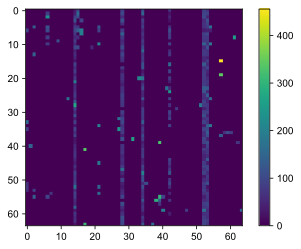

In [4]:
g = dpe.read(0, Tdly=500)
plt.imshow(g * 1e6)
plt.colorbar()

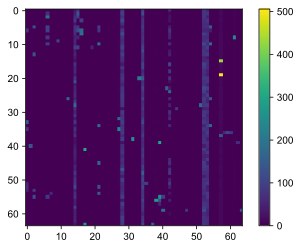

In [5]:
g = dpe.read(0, Tdly=1000, method='fast')
plt.imshow(g * 1e6)
plt.colorbar()

In [25]:
Vset = np.ones((64,64)) * 0.1
Vgate = np.ones((64,64)) * 0.1

Vset[:3,:3] = 0

Vgate[61:,61:] = 0

In [27]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dut = dpe.a0.dut
    dpe.a0.pic_write_batch(Vset, Vgate, mode=0)

In [14]:
#%%
table = [
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 2, 0, 1, 1, 0, 0, 0, 1, 1]
]

ns = [
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 1]
]

from lib_tcam import *

G = gen_tcam_2r(table).T

G = np.concatenate( (G, G, G, G, G, G))

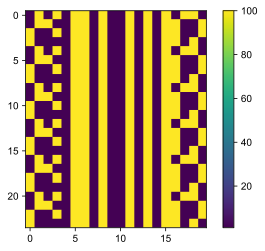

In [15]:
plt.imshow(G*1e6)
plt.colorbar()


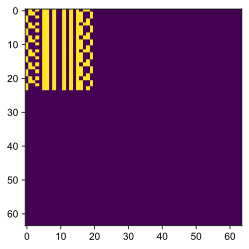

In [16]:
N = 64
targetTolerance = 4e-6

targetG = np.zeros((N,N))
targetG[:G.shape[0], :G.shape[1]] = G

targetGTolerance = np.full((N, N), np.inf)
targetGTolerance[:G.shape[0], :G.shape[1]] = targetTolerance

plt.imshow(targetG)

In [17]:
vSetRamp = np.arange(0.5, 4.4, 0.05)
vGateSetRamp = np.arange(0.5, 1.4, 0.05)
vResetRamp = np.arange(0.3, 1.5, 0.05)
vGateResetRamp = np.arange(5.0, 5.5, 0.5)

maxLoops = 5
array = 0

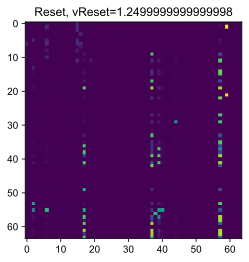

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002373B703DC8> (for post_execute):

In [ ]:
from dut_a0 import *

with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    
    targetGLow = targetG-targetTolerance
    targetGHigh = targetG+targetTolerance
    currentLoops = 0
    zeroMatrix = np.zeros((64,64))
    Vread=0.2
    # Do initial reading
    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
    input = [0x1<<i for i in range(64)]
    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
    # Now loop as long as any device is out of tolerance for target conductance and we haven't maxed out loops
    while ( (np.any(GMatrix < targetGLow) | np.any(GMatrix > targetGHigh)) & (currentLoops<=maxLoops) ):
        # Do SET operations for any devices too low        
        if np.any(GMatrix < targetGLow):
            print('Now turning ON')
            for vGateSet in vGateSetRamp:
                
                display.clear_output(wait=True)
                plt.imshow(GMatrix)
                plt.title(f'Set, Vgate={vGateSet}')
                display.display(plt.gcf())
                    
                print('Set, Vgate = ', vGateSet)
                for vSet in vSetRamp:
                    vGateSetMatrix = zeroMatrix + vGateSet * (GMatrix < targetGLow)
                    vWriteSetMatrix = zeroMatrix + vSet * (GMatrix < targetGLow)

#                     plt.figure(); plt.imshow(vGateSetMatrix); plt.colorbar()
#                     plt.figure(); plt.imshow(vWriteSetMatrix); plt.colorbar()

#                     assert(1==0)
                    #print('VWrite:', vWriteSetMatrix[0:3,0:3])
                    #print('VGate:', vGateSetMatrix[0:3,0:3])
                    pic_write_batch(vWriteSetMatrix, vGateSetMatrix, array=array, mode=1)
                    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
                    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
                    
                    
                    if np.all(GMatrix >= targetGLow):
                        break
                if np.all(GMatrix >= targetGLow):
                        break

        # Do RESET operations for any devices too high
        if np.any(GMatrix > targetGHigh):
            print('Now turning OFF')
            for vGateReset in vGateResetRamp:
                print('Reset, Vgate = ', vGateReset)
                for vReset in vResetRamp:
                    vGateResetMatrix = zeroMatrix + vGateReset * (GMatrix > targetGHigh)
                    vWriteResetMatrix = zeroMatrix + vReset * (GMatrix > targetGHigh)
                    pic_write_batch(vWriteResetMatrix, vGateResetMatrix, array=array, mode=0)
                    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
                    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
                    
                    display.clear_output(wait=True)
                    plt.imshow(GMatrix)
                    plt.title(f'Reset, vReset={vReset}')
                    display.display(plt.gcf())
                    
                    if np.all(GMatrix <= targetGHigh):
                        break
                if np.all(GMatrix <= targetGHigh):
                        break

        currentLoops=currentLoops+1
        print('Current loop = ', currentLoops)
    print('Completed with total loops = ', currentLoops)
#     return GMatrix    


In [4]:
plt.imshow(GMatrix*1e6); plt.colorbar()
# plt.clim(0, 100)

NameError: name 'GMatrix' is not defined

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


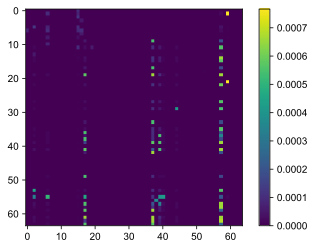

In [77]:
dpe.set_clock(50)

G = dpe.read(0, method='fast', Tdly=1000)
Vwrite = np.zeros((64,64)) 
Vgate = np.zeros((64,64))

plt.figure()
plt.imshow(G);plt.colorbar()

Vwrite[G>500e-6] = 2
Vgate[G>500e-6] = 5

In [109]:
Vwrite = np.zeros((64,64)) + 1.5
Vgate = np.zeros((64,64)) + 5

In [110]:
dpe.set_clock(50)

from dut_a0 import *

with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch(Vwrite, Vgate, array=1, mode=0, P_RESET=0x0fe)

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
2


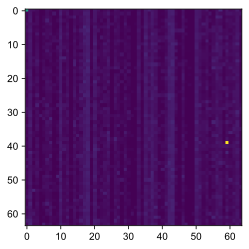

In [111]:
dpe.set_clock(50)

g = dpe.read(1, method='fast')

plt.imshow(g )
print(sum(sum(g>200e-6)))

In [168]:
dpe.set(0, Vset=2, Vgate=1.2)

....

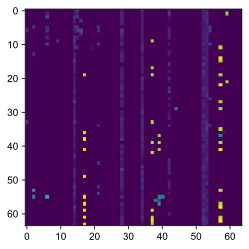

In [180]:
plt.imshow(dpe.read(0))

....

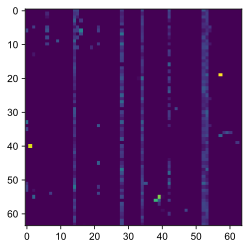

In [10]:
dpe.reset(0, Vreset=1.1, Vgate=5)

plt.imshow(dpe.read(0))

..

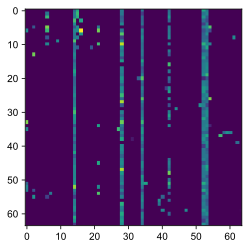

In [19]:
dpe.set(0, Vset=2, Vgate=1)

plt.imshow(dpe.read(0, method='slow', Tdly=500))

..0


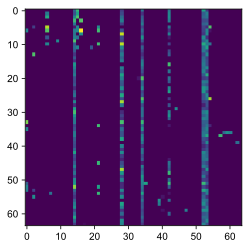

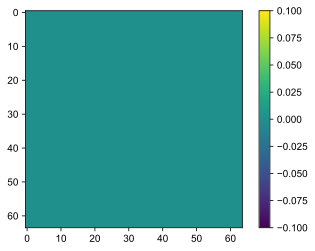

In [18]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vreset = np.ones((64,64)) * 1.5
Vgate = np.ones((64,64)) * 5.5

Vreset = Vreset * (g>200e-6)
Vgate = Vgate * (g>200e-6)
plt.figure()
plt.imshow(Vreset)
plt.colorbar()

print( sum(g.reshape(-1)>200e-6))

In [15]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch_ext(Vreset, Vgate, array=0, mode=0, Twidth=1000)

..3677


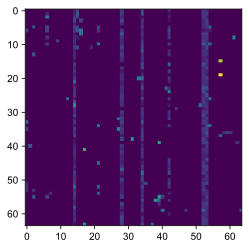

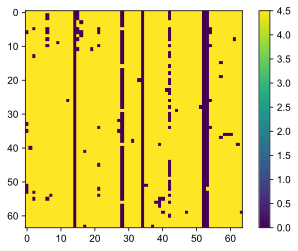

In [274]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vset = np.ones((64,64)) * 4.5
Vgate = np.ones((64,64)) * 1.5

Vset = Vset * (g<20e-6)
Vgate = Vgate * (g<20e-6)

plt.figure()
plt.imshow(Vset)
plt.colorbar()

print( sum(g.reshape(-1)<20e-6))

In [273]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch_ext(Vset, Vgate, array=0, mode=1, Twidth=10000)

.....................................

..0


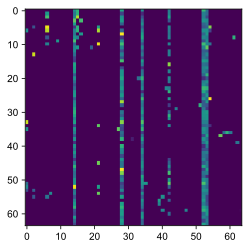

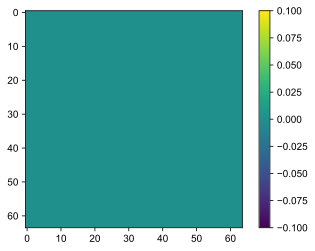

In [28]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vreset = np.ones((64,64)) * 1.5
Vgate = np.ones((64,64)) * 5.5

Vreset = Vreset * (g>200e-6)
Vgate = Vgate * (g>200e-6)
plt.figure()
plt.imshow(Vreset)
plt.colorbar()

print( sum(g.reshape(-1)>200e-6))

In [38]:
dpe.reset(0, Vreset, Vgate, verbose=True, Twidth=5.09e-6)

Resetting 0 devices...
Programming with external timing Twidth=5.1 us
